# Project Fletcher - Natural Language Processing

# Table of contents
1. [Introduction](#introduction)
2. [The Data](#The Data)
3. [Data Processing](#Data Processing)
4. [Natural Language Processing Techniques](#Natural Language Processing Techniques)
5. [Conclusion](#Conclusion)

 ## Introduction <a name="introduction"></a>

Accessing Crunchbase and Twitter’s APIs, merged recent tweets of 30,000 companies to predict a company’s operational status using advanced natural language processing techniques. Implemented TFIDF, Naive Bayes, Logistic Regression, and latent semantic indexing (LSI) models for classification. 

In [ ]:
# Imports

In [ ]:
import nltk
import pandas as pd
import numpy as np
import pickle
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.cross_validation import train_test_split
from IPython.display import Image
%matplotlib inline
import os
import json
import pickle
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import statsmodels.formula.api as smf
import patsy
import seaborn as sns
from seaborn import plt
from sklearn.linear_model import LinearRegression
from sklearn import metrics
from sklearn import tree
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from seaborn import plt
import random 
from __future__ import division
from matplotlib import pyplot
import matplotlib.pyplot as plt 
from sklearn.cross_validation import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import recall_score
from sklearn.metrics import classification_report
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.linear_model import LogisticRegression
from sklearn import linear_model
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import auc

## The Data <a name="The Data"></a>

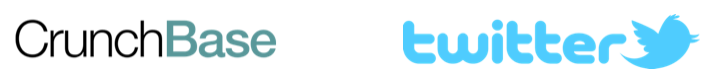

In [3]:
Image(filename='logos.png')

Crunchbase Data
* 28,781 companies
 * US Based
 * Twitter Handles
* Classification Column
 * Operating: 21,000 companies
 * Exits: 6,500 companies
 * Closed: 1,500 companies

Twitter Data
* Joined last 10 tweets
 * Long Text Strings
 * Used Tweepy Twitter API

 ## Data Processing <a name="Data Processing"></a>

In [ ]:
# specific imports
import time
import tweepy 
import requests
from requests_oauthlib import OAuth1
import cnfg
from os.path import expanduser
import pickle

In [ ]:
# Accessing Twitter API
home = expanduser("~")
config = cnfg.load(home + "/.twitter_config") 
def auth_twitter():
    auth = tweepy.OAuthHandler(config["consumer_key"],config["consumer_secret"])
    auth.set_access_token(config["access_token"],config["access_token_secret"])
    api=tweepy.API(auth)
    return api

In [ ]:
# Import Crunchbase Data & Filter Twitter Handle From URL, save new DF to csv
df = pd.read_csv("crunchbase_export_csv.csv")
df = df.dropna(subset=['twitter_url'], how='all')    
df["twitter_handle"] = df.twitter_url.map(lambda x: x.split("/")[-1].replace("@", "").strip())
df.to_csv("cruchbase.csv", index=False)

# Handle List Variable
handle_list = [row for row in df.twitter_handle]

In [ ]:
# Function to collect last ten tweets for a handle
def get_tweet_text(api, screen_name, limit=10):
    combined_text = ''
    for tweet in tweepy.Cursor(api.user_timeline, 
                               screen_name= screen_name, 
                               wait_on_rate_limit=True, 
                               wait_on_rate_limit_notify=True).items(limit):combined_text += '  ' + tweet.text
    return combined_text

The code below calls the Twitter API to collect the last ten tweets per each twitter handle, and is set up in a way to account for errors. This was a bottleneck process that took significant amount of time to run.

In [ ]:
# API Authentication     
twitter_api = auth_twitter() 
counter = 0
combined_tweets = []

while counter < 28781:
    handle = handle_list[counter]
    try:
        tweet_text = get_tweet_text(twitter_api, handle)
        combined_tweets.append((handle, tweet_text))
        counter += 1 
    except tweepy.TweepError:
        combined_tweets.append((handle, ''))
        counter += 1
        continue;
        
print counter        
print len(combined_tweets)
print combined_tweets[28780]

# save as pickle file
with open('finaltweets6.pkl', 'w') as picklefile:
    pickle. dump(combined_tweets, picklefile) 

Load tweet data and crunchbase data

In [3]:
with open('finaltweets6.pkl', 'r') as picklefile:
    comptweet1 = pickle.load(picklefile)
# separate into just handle and tweets
tweets = pd.DataFrame(comptweet1, columns=["twitter_handle", "tweets"])
# load crunchbase data with created handle column (done above)
dfcrunch = pd.read_csv('cruchbase.csv')

In [6]:
dfcrunch.head()

,company_name,domain,country_code,state_code,region,city,status,short_description,category_list,funding_rounds,...,first_funding_on,last_funding_on,closed_on,email,phone,cb_url,twitter_url,facebook_url,uuid,twitter_handle
0,Oro Inc.,orocrm.com,USA,CA,Los Angeles,Los Angeles,operating,"Open Source Tools for Businesses (CRM, B2B eCo...",B2B|CRM|E-Commerce|Enterprise Software|Open So...,1,...,2016-03-03,2016-03-03,NaN,info@orocrm.com,NaN,https://www.crunchbase.com/organization/oro,https://www.twitter.com/OroCRM,http://www.facebook.com/pages/Oro-CRM/42898686...,b667f47f-c810-7714-b6aa-c34ab3c8d1c2,OroCRM
1,Atlas Obscura,atlasobscura.com,USA,NY,New York City,Brooklyn,operating,"Atlas Obscura is a travel guide with articles,...",Leisure|Travel & Tourism,2,...,2015-02-24,2016-03-02,NaN,info@atlasobscura.com,NaN,https://www.crunchbase.com/organization/atlas-...,https://www.twitter.com/atlasobscura,http://www.facebook.com/atlasobscura,24af462f-7100-9130-db5c-0a38e960efc1,atlasobscura
2,Blippar,blippar.com,USA,NY,New York City,New York,operating,Blippar is the world�s leading image-recogniti...,Advertising|Augmented Reality|Computer Vision|...,3,...,2012-01-03,2016-03-02,NaN,info@blippar.com,NaN,https://www.crunchbase.com/organization/blippar,https://www.twitter.com/blippar,http://www.facebook.com/blippar,06f6c176-35cf-acdf-171e-240d23bc5fac,blippar
3,Calyxt,calyxt.com,USA,MN,MN - Other,Minnesota City,closed,Calyxt is an Agbiotech company focused on deve...,NaN,1,...,2016-03-02,2016-03-02,NaN,NaN,NaN,https://www.crunchbase.com/organization/calyxt,https://www.twitter.com/calyxt_inc,NaN,0a4d4b3d-ac4d-566f-923f-5ca1995296ee,calyxt_inc
4,Coop Fuels,coopfuels.com,USA,DC,"Washington, D.C.",Washington,operating,Retailer of E85 & Renewable Diesel,Clean Technology|Fuels|Internet|Renewable Ener...,1,...,2016-03-02,2016-03-02,NaN,NaN,NaN,https://www.crunchbase.com/organization/coop-f...,https://www.twitter.com/coopfuels,https://www.facebook.com/coopfuels,93366aa5-6417-4599-260d-897eaf9d65c5,coopfuels


Merge Crunchbase and Tweet Dataframes

In [7]:
company_df = pd.merge(tweets, dfcrunch, how="inner", left_index=True, right_index=True)

Create target column labeling IPOS and Acquired companies as "Exits"

In [8]:
company_df["target"] = company_df.status.map({"operating": "operating", 
                       "closed": "closed", 
                       "ipo": "exits", 
                       "acquired": "exits"})

Analyze the Target Split - Would be better if distribution was more even

In [9]:
company_df.target.value_counts()

operating    20955
exits         6377
closed        1449
Name: target, dtype: int64

In [12]:
company_df.tweets

0          Verifying myself: I am orocrm on Keybase.io....
1          No detail was too small when it came to set ...
2          Imagine a world where all #art is interactiv...
3          Calyxt Acquires Land for New Headquarters Fa...
4          Lower Cost, Lower Carbon, Drive E85! https:/...
5          @eadamuk That's the plan :)  Plan ahead of D...
6          RT @meredithlaurenm: Somewhat obsessed with ...
7          RT @REI: On the blog: @HagePhoto takes a @go...
8          Shivam Dikshit, co-founder of #Iotfy, speaks...
9          Join us on March 17th for our ACT webinar! C...
10         @social_studio Hi Jessica, reach out to help...
11         23 Ways To Improve Your Lazy Night In https:...
12         Medicare May Not Be Able to Lower Costs Even...
13         RT @techcirclein: #Office #assistant #app Sk...
14         RT @SemyonDukach: @krisztinaholly @techstars...
15         Check out our contest with ItsPotLuck - http...
16         Did you miss hiQ Elevate Santa Clara?  That'.

In [13]:
#company_df.sort_index(by = 'last_funding_on', ascending = True).head(100)

Create Predictor "X" and Response "Y" sections. Because this project will use natural language processing techniques, there is only one predictor column "tweets".

In [14]:
X = company_df.tweets
y = company_df.target

 ## Natural Language Processing Techniques <a name="Natural Language Processing Techniques"></a>

### Baseline: TFDIF with Naive Bayes

First we split the raw data into training and testing portions

In [15]:
X_train, X_test, y_train, y_test = train_test_split(company_df.tweets, y, test_size=0.2)

In [16]:
print X_test.shape, X_train.shape, y_test.shape, y_train.shape

(5757,) (23024,) (5757,) (23024,)


Then we transform X_train using TFIDF Count Vectorizer. "TF" represents a words frequency in a document while "IDF" represents inverse frequency in the corpus. 

In [17]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB

# Setup Vectorizer with parameters
vectorizer = TfidfVectorizer(stop_words="english", ngram_range=(1,2), analyzer='word',
                                  token_pattern='\\b[a-z][a-z]+\\b')
# Transform the X_train data
X_train_vect = vectorizer.fit_transform(X_train)

Fit the vectorized training data predictors (X_train_vect) on the training data response (y_train)

In [18]:
nb_clf = MultinomialNB().fit(X_train_vect, y_train)

In [19]:
# Transform the X_test data
X_test_vect = vectorizer.transform(X_test)

The transformation created a much larger sparse matrix with 1.4 million columns

In [20]:
print X_test_vect.shape

(5757, 1408956)


Create a variable for vectorized test predictions

In [22]:
y_pred_nb = nb_clf.predict(X_test_vect)

How well did the model do with it's predictions? Not very well. It predicted every company based on its tweets as "operating" (third column in confusion matrix below)

In [23]:
# nb_clf.classes_ ==> array(['closed', 'exits', 'operating'], dtype='|S9')
confusion_matrix(y_test, y_pred_nb)

array([[   0,    0,  288],
       [   0,    0, 1296],
       [   0,    0, 4173]])

By predicting every company as "operating", the model scored an accuracy rate of 72%

In [25]:
nb_clf.score(X_test_vect, y_test)

0.7248566961959354

Classification Report

In [28]:
print metrics.accuracy_score(y_test, y_pred_nb)
print metrics.classification_report(y_test, y_pred_nb)

0.724856696196
             precision    recall  f1-score   support

     closed       0.00      0.00      0.00       288
      exits       0.00      0.00      0.00      1296
  operating       0.72      1.00      0.84      4173

avg / total       0.53      0.72      0.61      5757



/Users/Cronin/anaconda/lib/python2.7/site-packages/sklearn/metrics/classification.py:1074: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


## Detailed: GENSIM

Imports

In [29]:
# gensim
from gensim import corpora, models, similarities, matutils
# sklearn
from sklearn import datasets
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.cluster import KMeans
# logging for gensim (set to INFO)
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)

In [30]:
# Create a CountVectorizer for parsing/counting words
count_vectorizer = CountVectorizer(analyzer='word',
                                  ngram_range=(1,2), stop_words='english',
                                  token_pattern='\\b[a-z][a-z]+\\b')

Create the term-document matrix. Transpose it so the terms are the rows

In [31]:
ng_vecs = count_vectorizer.fit_transform(company_df.tweets).transpose()
ng_vecs.shape

(1705443, 28781)

** ??? Difference from Above ??? **

In [32]:
ng_vecs_x = count_vectorizer.fit_transform(company_df.tweets)

* Convert to gensim: need to convert our sparse scipy matrix to a gensim-friendly object called a Corpus: 
* Convert sparse matrix of counts to a gensim corpus

In [33]:
corpus = matutils.Sparse2Corpus(ng_vecs)

Map matrix rows to words (tokens)

In [34]:
# We need to save a mapping (dict) of row id to word (token) for later use by gensim:
id2word = dict((v, k) for k, v in count_vectorizer.vocabulary_.iteritems())

### Logistic Regression

Train/test/split using ng_vecs (Count Vect). Here, we are splitting vectorized data

In [35]:
X_train, X_test, y_train, y_test = train_test_split(ng_vecs_x, company_df.target)

In [ ]:
print X_test.shape, X_train.shape, y_test.shape, y_train.shape
# output: print X_test.shape, X_train.shape, y_test.shape, y_train.shape
#              (7196, 1705443), (21585, 1705443), (7196,), (21585,)

X_test.shape above means there are 7196 number of terms and 1706443 number of docs

Model with Logistic Reg and predict on Testing data

In [37]:
nb_nb = LogisticRegression().fit(X_train, y_train)

Unlike TFDIF with Naive Bayes, made predictions for each target category and had slighlty higher accuracy score of 73.6%

In [38]:
y_pred_reg = nb_nb.predict(X_test)
confusion_matrix(y_test, y_pred_reg)

array([[  12,   36,  324],
       [  15,  328, 1255],
       [  21,  246, 4959]])

In [39]:
print metrics.accuracy_score(y_test, y_pred_reg)
print metrics.classification_report(y_test, y_pred_reg)

0.736381322957
             precision    recall  f1-score   support

     closed       0.25      0.03      0.06       372
      exits       0.54      0.21      0.30      1598
  operating       0.76      0.95      0.84      5226

avg / total       0.68      0.74      0.68      7196



### Naive Bayes

In [40]:
nb_nb = MultinomialNB().fit(X_train, y_train)

In [41]:
y_pred_reg = nb_nb.predict(X_test)
confusion_matrix(y_test, y_pred_reg)

array([[   1,   60,  311],
       [   3,  284, 1311],
       [   8,  338, 4880]])

In [42]:
print metrics.accuracy_score(y_test, y_pred_reg)
print metrics.classification_report(y_test, y_pred_reg)

0.717759866593
             precision    recall  f1-score   support

     closed       0.08      0.00      0.01       372
      exits       0.42      0.18      0.25      1598
  operating       0.75      0.93      0.83      5226

avg / total       0.64      0.72      0.66      7196



### KNN with LogReg 

In [44]:
# Fit KNN classifier to training set 
knn = KNeighborsClassifier(n_neighbors=3)  
knn.fit(X_train, y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=3, p=2,
           weights='uniform')

In [ ]:
# Cosine Distance Metric (Future Reference)
# import sklearn.metrics.pairwise as smp
# metric=smp.cosine_distances

In [45]:
y_pred_knn = knn.predict(X_test)

In [46]:
# Score against test set
knn.score(X_test, y_test)

0.61381322957198448

In [47]:
confusion_matrix(y_test, y_pred_knn)

array([[  21,   41,  310],
       [  31,  280, 1287],
       [  63, 1047, 4116]])

In [48]:
print metrics.accuracy_score(y_test, y_pred_knn)
print metrics.classification_report(y_test, y_pred_knn)

0.613813229572
             precision    recall  f1-score   support

     closed       0.18      0.06      0.09       372
      exits       0.20      0.18      0.19      1598
  operating       0.72      0.79      0.75      5226

avg / total       0.58      0.61      0.59      7196



### LSI

LSI requires us to go one step further than LDA in preprocessing, we need to calculate TFIDF weights from our word counts term-document matrix. Here's how we do it in gensim:


In [50]:
# Create a TFIDF transformer from our word counts (equivalent to "fit" in sklearn)
tfidf = models.TfidfModel(corpus)

In order to give each document vectors in the "TFIDF space" we need to actually do the transform step with our TfidfModel like so:

In [51]:
# Create a TFIDF vector for all documents from the original corpus ("transform" in sklearn)
tfidf_corpus = tfidf[corpus]

### SVD

Now that we've taken care of the TFIDF bit, let's crank through the SVD and build the LSI space:

* Build an LSI space from the input TFIDF matrix, mapping of row id to word, and num_topics
* num_topics is the number of dimensions to reduce to after the SVD
* Analagous to "fit" in sklearn, it primes an LSI space

In [52]:
lsi = models.LsiModel(tfidf_corpus, id2word=id2word, num_topics=300)

Now that we have a trained LSI space, we want to do the transform step to figure out where all of the original documents lie in that num_topics=300 dimensional space:

In [53]:
# Retrieve vectors for the original tfidf corpus in the LSI space ("transform" in sklearn)
lsi_corpus = lsi[tfidf_corpus]

In [54]:
lsi_vecs = lsi[tfidf_corpus]

In [55]:
# Dump the resulting document vectors into a list so we can take a look
doc_vecs = [doc for doc in lsi_corpus]

### Machine Learning with LSI Vectors

We have (very good, 300-dimensional) vectors for our documents now! So we can do any machine learning we want on our documents!

In [56]:
# Convert the gensim-style corpus vecs to a numpy array for sklearn manipulations
X = matutils.corpus2dense(lsi_vecs, num_terms=300).transpose()
X.shape

(28781, 300)

In [57]:
# splitting vectorized data
X_train, X_test, y_train, y_test = train_test_split(X, company_df.target)

In [58]:
print X_test.shape, X_train.shape, y_test.shape, y_train.shape

(7196, 300) (21585, 300) (7196,) (21585,)


In [59]:
# Model with Logistic Reg
from sklearn.linear_model import LogisticRegression
nb_reg = LogisticRegression().fit(X_train, y_train)

In [60]:
X_train

array([[ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.0125379 ,  0.01345554,  0.00200712, ...,  0.0068414 ,
         0.009197  ,  0.00816096],
       [ 0.04993167,  0.06928454,  0.01420905, ...,  0.00149996,
         0.01366029, -0.00045139],
       ..., 
       [ 0.01419006,  0.00170672, -0.00052629, ...,  0.00319136,
         0.00126077,  0.0079386 ],
       [ 0.06213442,  0.02927945,  0.00270959, ..., -0.00311402,
         0.00875806,  0.0017483 ],
       [ 0.08657596, -0.06859653, -0.04042228, ..., -0.0044482 ,
        -0.00526163,  0.01018806]], dtype=float32)

In [61]:
y_pred_reg = nb_reg.predict(X_test)

In [62]:
print y_pred_reg.shape

(7196,)


In [63]:
confusion_matrix(y_test, y_pred_reg)

array([[   3,    4,  355],
       [   2,   34, 1556],
       [   0,   15, 5227]])

In [64]:
print metrics.accuracy_score(y_test, y_pred_reg)
print metrics.classification_report(y_test, y_pred_reg)

0.731517509728
             precision    recall  f1-score   support

     closed       0.60      0.01      0.02       362
      exits       0.64      0.02      0.04      1592
  operating       0.73      1.00      0.84      5242

avg / total       0.71      0.73      0.63      7196



 ## Conclusion <a name="Conclusion"></a>